In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Print the result
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


**Design a query to retrieve the last 12 months of precipitation data and plot the results.**

In [10]:
# Starting from the most recent data point in the database. 
# Convert most recent date string to a datetime object.
most_recent_datetime = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_datetime - dt.timedelta(days=365)

print(f"Date one year before the most recent date: {one_year_ago.date()}")


Date one year before the most recent date: 2016-08-23


In [11]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago.date())
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "precipitation"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("date")

# Display the first 5 rows to confirm sorting
precipitation_df.head()

,date,precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15


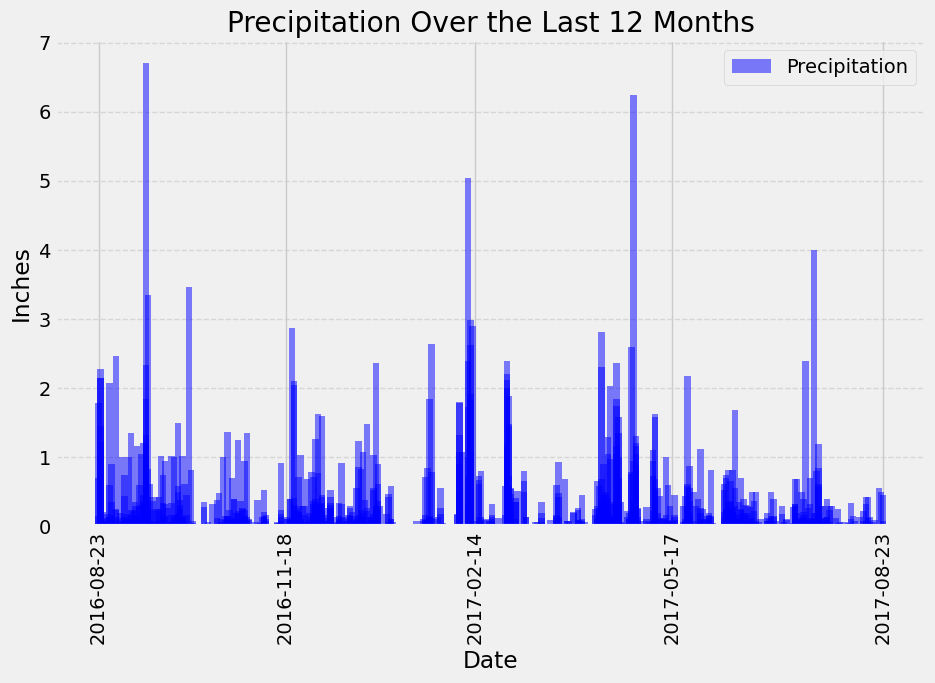

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
# Convert date column to datetime format
precipitation_df["date"] = pd.to_datetime(precipitation_df["date"])

# Set figure size
plt.figure(figsize=(10, 6))

# Plot bar chart
plt.bar(precipitation_df["date"], precipitation_df["precipitation"], width=3, color='b', alpha=0.5, label="Precipitation")

# Formatting
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation Over the Last 12 Months")
plt.legend()

#Adjust x-axis
tick_positions = np.linspace(0, len(precipitation_df) - 1, 5, dtype=int)  # Select 5 positions
tick_labels = precipitation_df.iloc[tick_positions]["date"].dt.strftime('%Y-%m-%d')  # Format dates properly

plt.xticks(ticks=precipitation_df.iloc[tick_positions]["date"], labels=tick_labels, rotation=90)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()



In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df["precipitation"].describe()
summary_statistics_df = pd.DataFrame(summary_stats)
summary_statistics_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f"Total number of stations in the dataset: {total_stations}")

Total number of stations in the dataset: 9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# Print the results
print("Most Active Stations:")
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]  # First station in the sorted list

# Query to calculate min, max, and avg temperature for the most active station
temp_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station_id)
    .all()
)

# Print the results
min_temp, max_temp, avg_temp = temp_stats[0]  # Extract values from the result tuple
print(f"Most Active Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


Most Active Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
tobs_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago.date())
    .all()
)

# Convert query results to a list
tobs_values = [temp[0] for temp in tobs_data]

# Print the first 5 values to verify
print(tobs_values[:5])


[77.0, 77.0, 80.0, 80.0, 75.0]


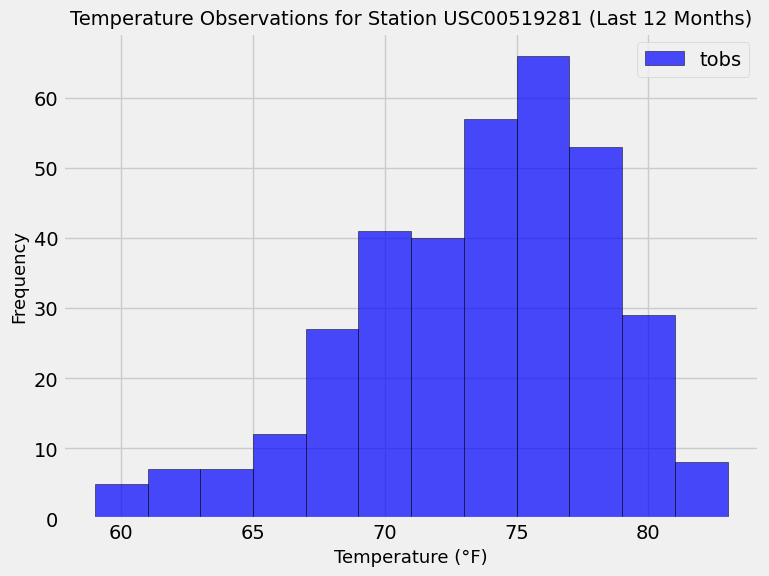

In [18]:
# Set figure size
plt.figure(figsize=(8,6))

# Plot histogram
plt.hist(tobs_values, bins=12, color="b", alpha=0.7, edgecolor="black", label="tobs")

# Formatting
plt.xlabel("Temperature (°F)", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title(f"Temperature Observations for Station {most_active_station_id} (Last 12 Months)", fontsize=14)
plt.legend()

# Show the plot
plt.show()


# Close Session

In [19]:
# Close Session
session.close()